In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
import os
import dlib
plt.rcParams['figure.figsize'] = [15, 10]


In [2]:
casc_path = 'source//haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(casc_path)

(<Axes: title={'center': 'Grayscale Image'}>,
 Text(0.5, 1.0, 'Grayscale Image'),
 (np.float64(-0.5), np.float64(1023.5), np.float64(575.5), np.float64(-0.5)))

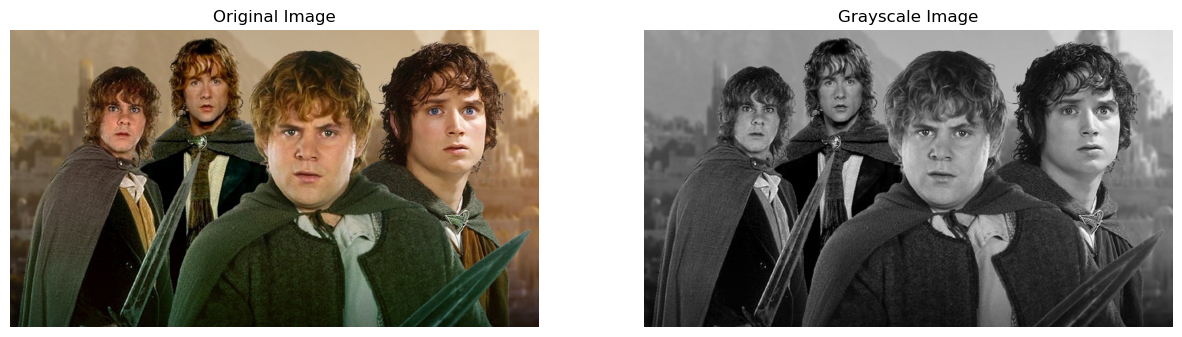

In [3]:
img = cv2.imread('source//group.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Let's plot the image
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(gray, cmap='gray'), plt.title('Grayscale Image'), plt.axis('off')



Number of detected faces: 4
rectangles[[(786, 116) (941, 270)], [(335, 76) (424, 166)], [(494, 167) (648, 322)], [(163, 128) (270, 235)]]


(<matplotlib.image.AxesImage at 0x22c6d04f650>,
 Text(0.5, 1.0, 'Detected Faces'),
 (np.float64(-0.5), np.float64(1023.5), np.float64(575.5), np.float64(-0.5)))

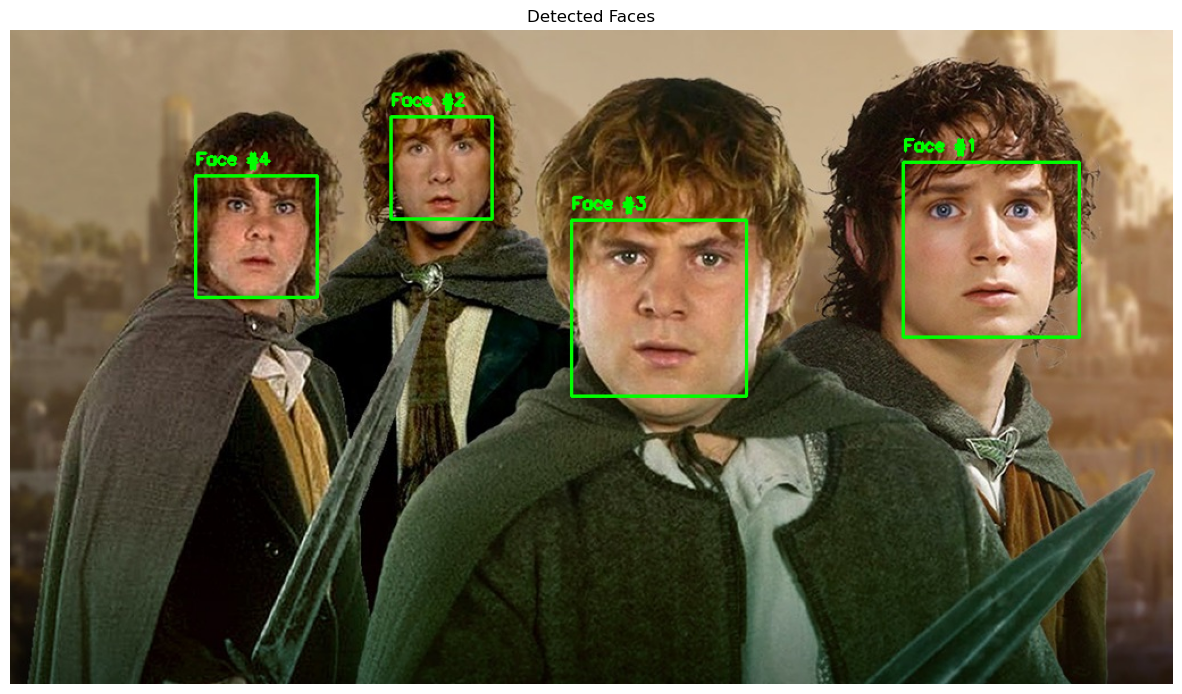

In [4]:
# Let's load the detector
detector = dlib.get_frontal_face_detector()

# 1 --> upsampling factor
rects = detector(gray, 1)

marked_img = img.copy()

print('Number of detected faces:', len(rects))
print(rects)
faces_dlib_img = []
for i, rect in enumerate(rects):
    x1 = rect.left()
    y1 = rect.top()
    x2 = rect.right()
    y2 = rect.bottom()
    cv2.rectangle(marked_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(marked_img, f'Face #{i+1}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    faces_dlib_img.append(gray[y1:y2, x1:x2])
plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB)), plt.title('Detected Faces'), plt.axis('off')


Face 0 - keypoints: 68 descriptors: (68, 128)
Face 1 - keypoints: 83 descriptors: (83, 128)
Face 2 - keypoints: 71 descriptors: (71, 128)
Face 3 - keypoints: 133 descriptors: (133, 128)


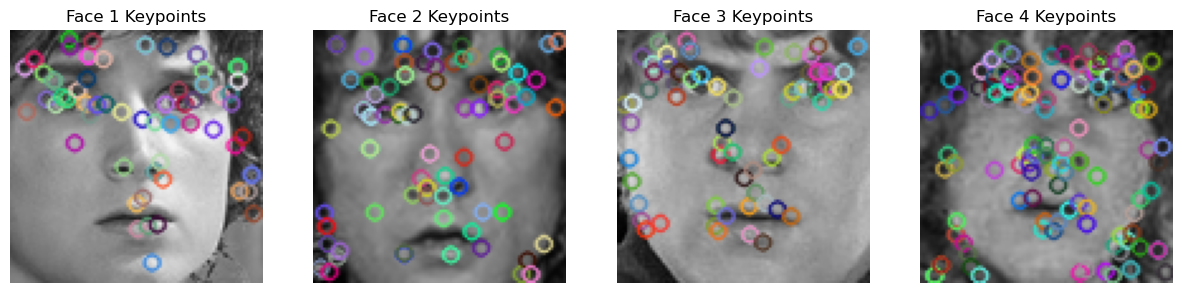

In [5]:
#Тепер обчислюємо дескриптори для кожного з детектованих обличь
sift = cv2.SIFT_create()
faces_kp = []
faces_des = []
for i, face in enumerate(faces_dlib_img):
    face_gray = face
    face_gray = cv2.resize(face_gray, (100, 100)) 
    kp, des = sift.detectAndCompute(face_gray, None)
    faces_kp.append(kp)
    faces_des.append(des)
    print('Face', i, '- keypoints:', len(kp), 'descriptors:', des.shape)
    img_kp = cv2.drawKeypoints(face_gray, kp, None)
    plt.subplot(1, len(faces_dlib_img), i+1), plt.imshow(img_kp, cmap='gray') 
    plt.title(f'Face {i+1} Keypoints'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x22c6d8e9a30>,
 Text(0.5, 1.0, 'Face to be found'),
 (np.float64(-0.5), np.float64(128.5), np.float64(129.5), np.float64(-0.5)))

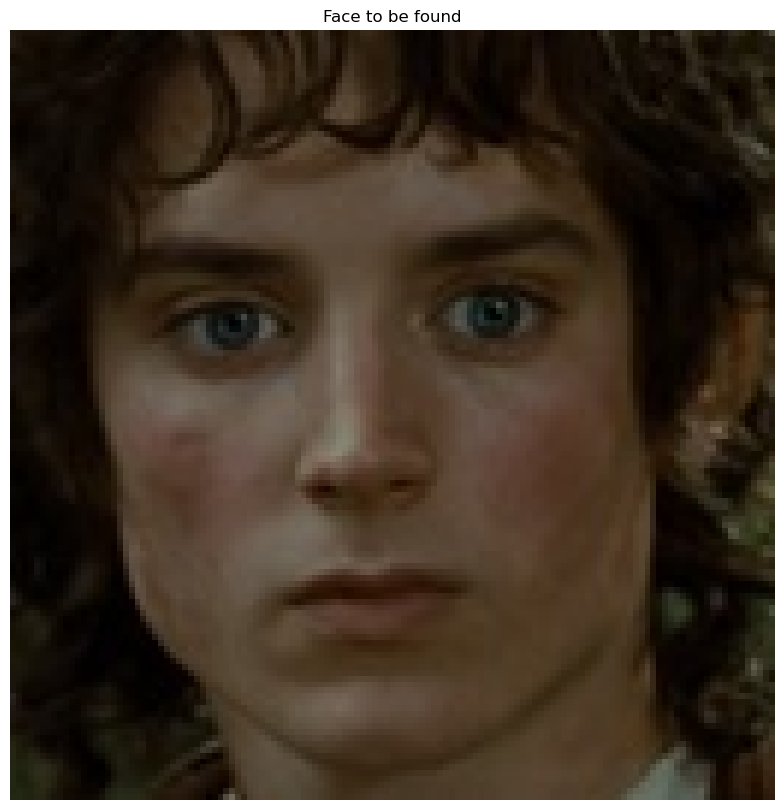

In [6]:
#Завантажуємо зображення обличча, яке будемо шукати серед детектованих
face_1 = cv2.imread('source//face_1.jpg')
face_1 = cv2.cvtColor(face_1, cv2.COLOR_BGR2RGB)
plt.imshow(face_1), plt.title('Face to be found'), plt.axis('off')


(<matplotlib.image.AxesImage at 0x22c6d92a5d0>,
 Text(0.5, 1.0, 'Face to be found - Grayscale & Resized'),
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

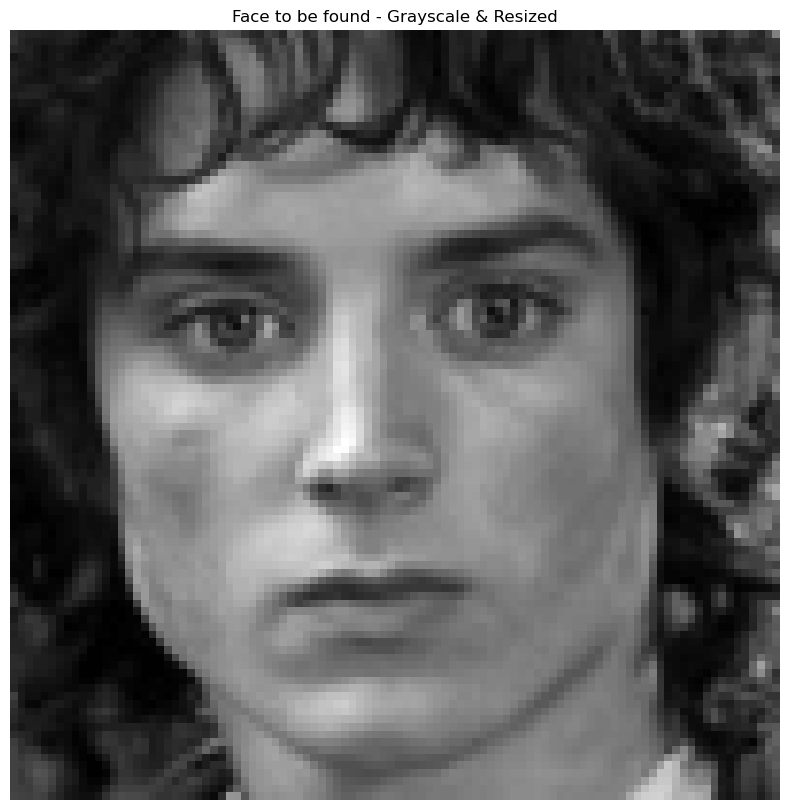

In [7]:
face_1_gray = cv2.cvtColor(face_1, cv2.COLOR_RGB2GRAY)
face_1_gray = cv2.resize(face_1_gray, (100, 100)) 
plt.imshow(face_1_gray, cmap='gray'), plt.title('Face to be found - Grayscale & Resized'), plt.axis('off')


Face 1 - keypoints: 53 descriptors: (53, 128)


(<matplotlib.image.AxesImage at 0x22c6d9970e0>,
 Text(0.5, 1.0, 'Face 1 Keypoints'),
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

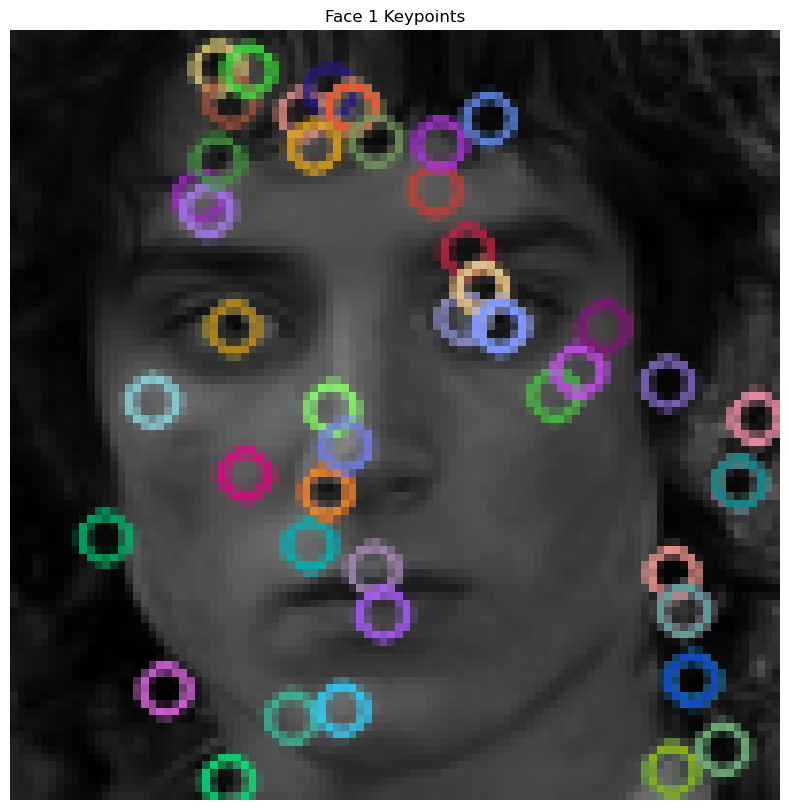

In [8]:
#Обчислюємо дескриптор обличчя, яке будемо шукати
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(face_1_gray, None)
print('Face 1 - keypoints:', len(kp1), 'descriptors:', des1.shape)
img_kp1 = cv2.drawKeypoints(face_1_gray, kp1, None)
plt.imshow(img_kp1, cmap='gray'), plt.title('Face 1 Keypoints'), plt.axis('off')


In [9]:
#Порівнюємо дескриптори обличчя, яке шукаємо, з дескрипторами детектованих обличь
bf = cv2.BFMatcher()  
matches_all = []
for i, des2 in enumerate(faces_des):
    matches = bf.knnMatch(des1, des2, k=2) 
    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
    matches_all.append(good)
    print('Face', i, '- matches:', len(matches), 'good matches:', len(good))
    img_matches = cv2.drawMatchesKnn(face_1, kp1, faces_dlib_img[i], faces_kp[i], good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.subplot(1, len(faces_dlib_img), i+1), plt.imshow(img_matches)

Face 0 - matches: 53 good matches: 4
Face 1 - matches: 53 good matches: 0
Face 2 - matches: 53 good matches: 1
Face 3 - matches: 53 good matches: 0


Best face index: 0


(<matplotlib.image.AxesImage at 0x22c6f3cb260>,
 Text(0.5, 1.0, 'Best Matching Face'),
 (np.float64(-0.5), np.float64(154.5), np.float64(153.5), np.float64(-0.5)))

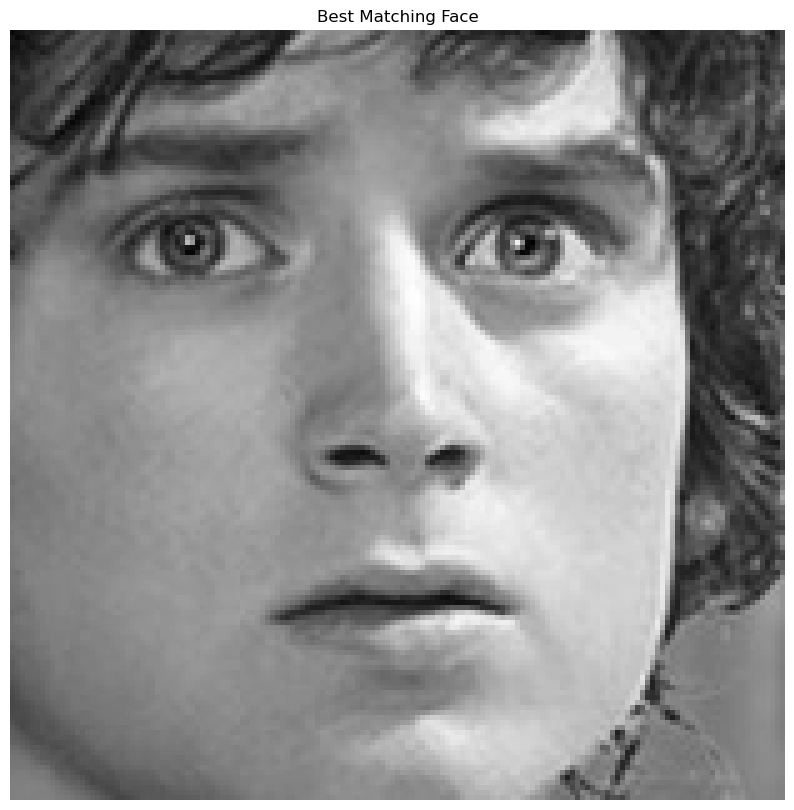

In [10]:
#Обираємо обличчя з найбільшою кількістю співпадінь
best_face_idx = np.argmax([len(m) for m in matches_all])    
print('Best face index:', best_face_idx)
plt.imshow(faces_dlib_img[best_face_idx], cmap='gray'), plt.title('Best Matching Face'), plt.axis('off')

In [ ]:
def find_face(query_face, detected_faces):
    """
    Знаходимо обличчя, що найкраще збігається, серед detected_faces для заданого query_face.

    Параметри:
    - query_face: numpy.ndarray, RGB-зображення обличчя, яке потрібно знайти
    - detected_faces: список numpy.ndarray, кожен елемент якого є RGB-зображенням обличчя

    Повертає: словник з ключами:
    - best_idx: індекс обличчя з найкращим збігом у списку detected_faces (або None, якщо немає дійсних збігів)
    - matches_counts: список кількостей хороших збігів для кожного виявленого обличчя
    - matches_all: список списків хороших збігів (для drawMatchesKnn) для кожного обличчя
    - kp_query, des_query: ключові точки та дескриптори обличчя для запиту (des_query може бути None)
    """
    # Create necessary objects and define parameters inside the function
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()
    size = (100, 100)  # Target size for descriptor computation
    ratio = 0.75      # Lowe's ratio test threshold

    # Prepare query face: convert to gray and resize
    if query_face is None or query_face.size == 0:
        return {"best_idx": None, "matches_counts": [], "matches_all": [], "kp_query": None, "des_query": None}

    try:
        query_gray = cv2.cvtColor(query_face, cv2.COLOR_RGB2GRAY)
    except Exception:
        # If image is already gray
        query_gray = query_face.copy()

    query_gray = cv2.resize(query_gray, size)
    kp_query, des_query = sift.detectAndCompute(query_gray, None)

    matches_all = []
    matches_counts = []

    for face in detected_faces:
        # Safe checks
        if face is None or face.size == 0:
            matches_all.append([])
            matches_counts.append(0)
            continue

        try:
            face_gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
        except Exception:
            face_gray = face.copy()

        face_gray = cv2.resize(face_gray, size)
        kp2, des2 = sift.detectAndCompute(face_gray, None)

        if des_query is None or des2 is None:
            matches_all.append([])
            matches_counts.append(0)
            continue

        # kNN match and Lowe ratio test
        knn = bf.knnMatch(des_query, des2, k=2)
        good = []
        # Ensure knn is not empty and contains pairs
        if knn and len(knn[0]) == 2:
            for m, n in knn:
                if m.distance < ratio * n.distance:
                    good.append([m])

        matches_all.append(good)
        matches_counts.append(len(good))

    if not matches_counts:
        best_idx = None
    else:
        best_idx = int(np.argmax(matches_counts)) if any(matches_counts) else None

    return {
        "best_idx": best_idx,
        "matches_counts": matches_counts,
        "matches_all": matches_all,
        "kp_query": kp_query,
        "des_query": des_query,
    }



Processing face_1.jpg: Best match index: 0, Matches counts: [4, 0, 1, 0]


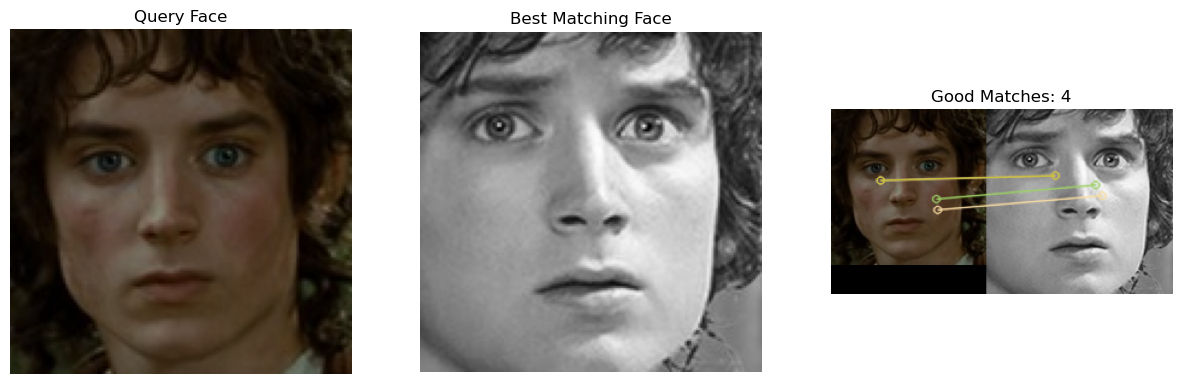

Processing face_2.jpg: Best match index: 1, Matches counts: [0, 3, 1, 0]


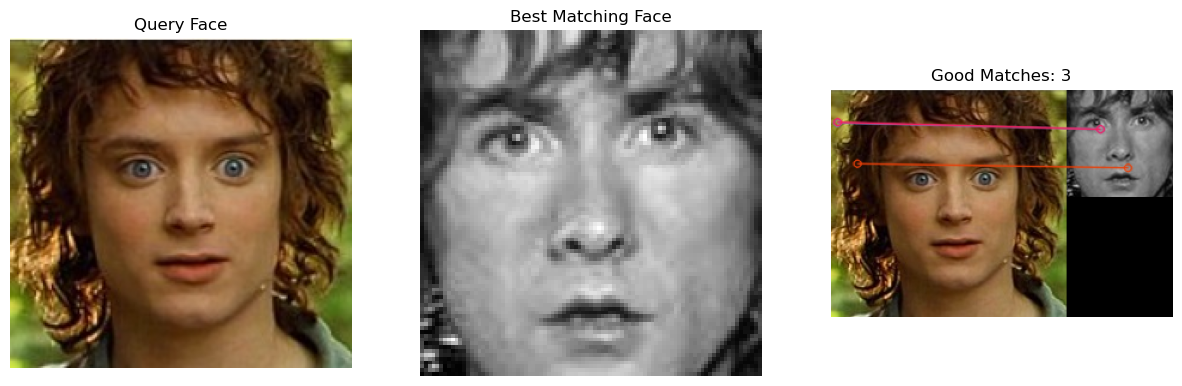

Processing face_3.jpg: Best match index: 1, Matches counts: [0, 1, 1, 0]


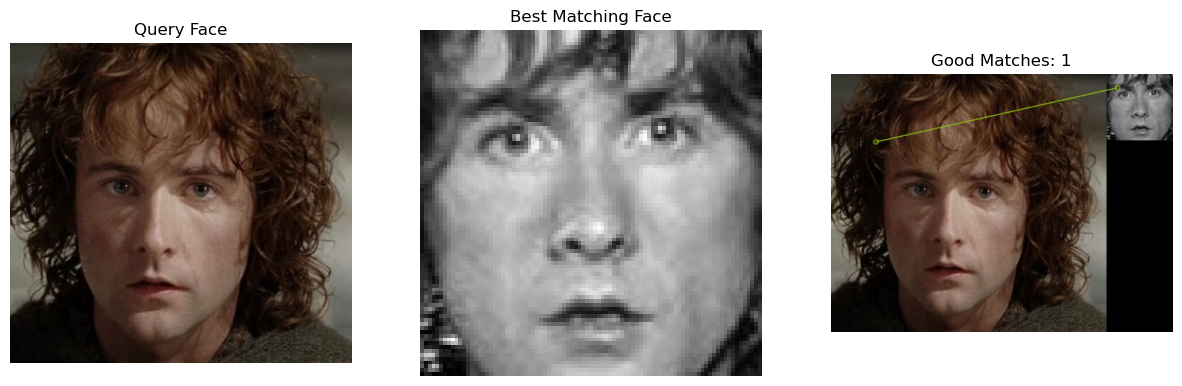

Processing face_4.jpg: Best match index: 0, Matches counts: [1, 0, 1, 0]


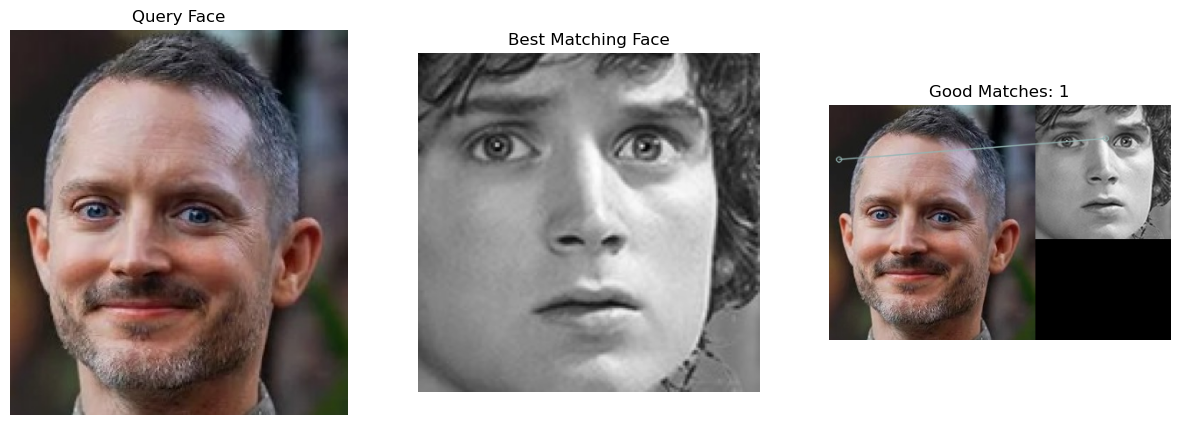

Processing face_5.jpg: Best match index: 3, Matches counts: [1, 0, 0, 2]


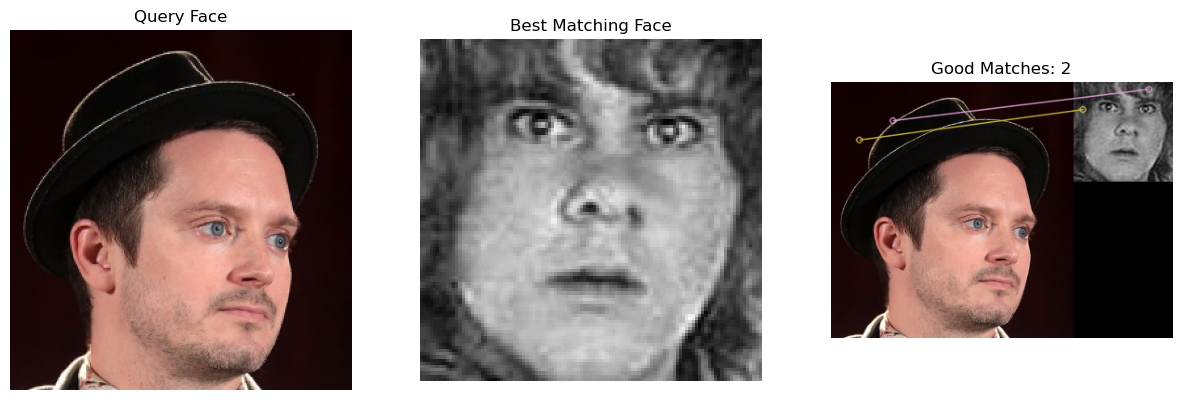

Processing face_6.jpg: Best match index: 0, Matches counts: [2, 1, 0, 0]


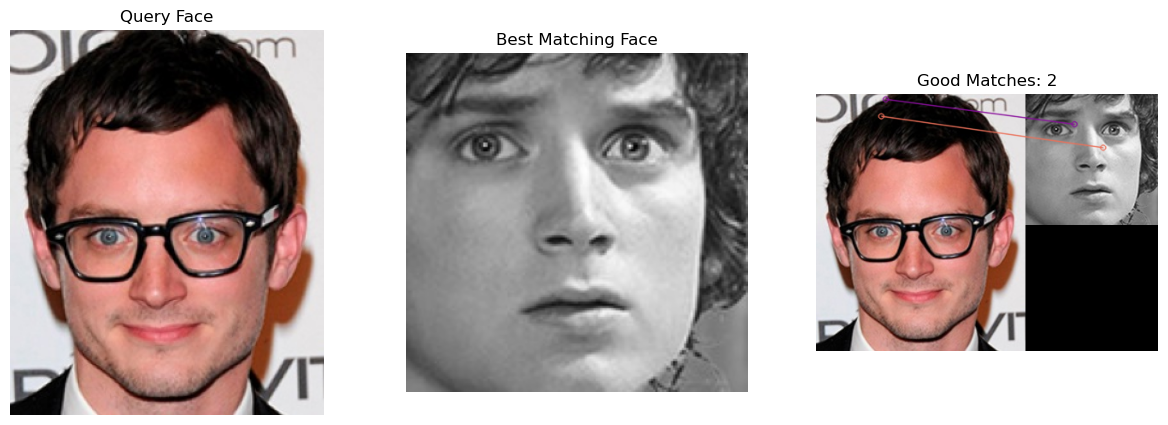

Processing face_7.jpg: Best match index: None, Matches counts: [0, 0, 0, 0]


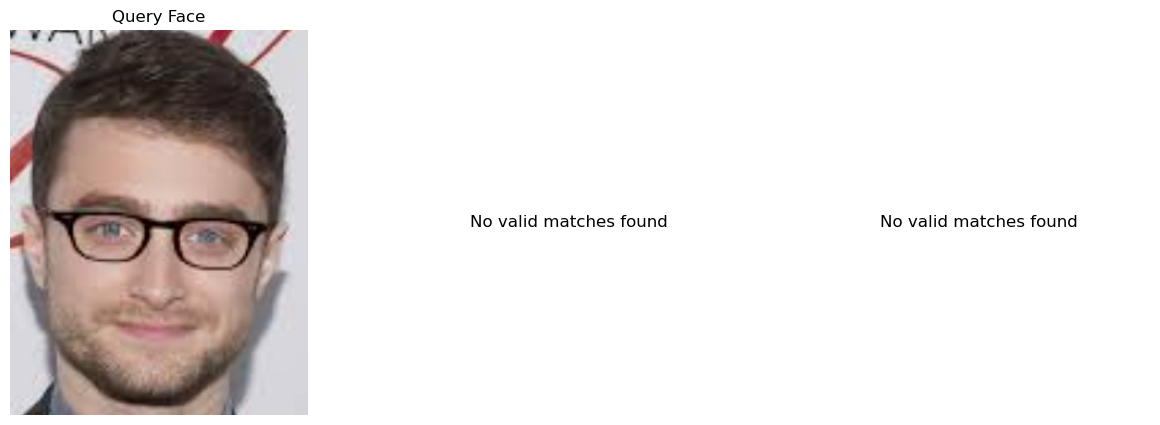

In [14]:
#створюємо цикл, який проходить по усим файлам в source, які починаються на face_ і закінчуються на .jpg
#для кожного знайденого файлу виконуємо пошук обличчя серед детектованих
#в кінці виводимо таблицію із зліва - обличча із файлу face_i.jpg, справа - найкраще співпадіння серед детектованих, ще правіше - числова оцінка співпадіння
for file in os.listdir('source'):
    if file.startswith('face_') and file.endswith('.jpg'):
        query_face = cv2.imread(os.path.join('source', file))
        query_face = cv2.cvtColor(query_face, cv2.COLOR_BGR2RGB)

        result = finde_fice(query_face, faces_dlib_img, size=(100, 100), ratio=0.75)

        best_idx = result['best_idx']
        matches_counts = result['matches_counts']
        matches_all = result['matches_all']
        kp_query = result['kp_query']
        des_query = result['des_query']

        print(f'Processing {file}: Best match index: {best_idx}, Matches counts: {matches_counts}')

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(query_face), plt.title('Query Face'), plt.axis('off')

        if best_idx is not None:    
            plt.subplot(1, 3, 2)
            plt.imshow(faces_dlib_img[best_idx], cmap='gray'), plt.title('Best Matching Face'), plt.axis('off')

            img_matches = cv2.drawMatchesKnn(query_face, kp_query, faces_dlib_img[best_idx], 
                                             faces_kp[best_idx], matches_all[best_idx], None, 
                                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            plt.subplot(1, 3, 3)
            plt.imshow(img_matches), plt.title(f'Good Matches: {len(matches_all[best_idx])}'), plt.axis('off')
        else:
            plt.subplot(1, 3, 2)
            plt.text(0.5, 0.5, 'No valid matches found', horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.text(0.5, 0.5, 'No valid matches found', horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

        plt.show()


5 із 7 -  непоганий результат, але не так щоб і дуже хороший. Дуже залежить від ракурса фотографії, та умов здійснення знімка. Бажано мати не одне зображення обличча, яке шукаємо, а де-кілька, тоді можна буде більш вірогідно знаходити обличча серед багатьох різних облич.